# Optimizing training and inference

In this notebook, we will discuss different ways to reduce memory and compute usage during training and inference.

## Prepare training script (1 point)

When training large models, it is usually a best practice not to use Jupyter notebooks, but run a **separate script** for training which could have command-line flags for various hyperparameters and training modes. This is especially useful when you need to run multiple experiments simultaneously (e.g. on a cluster with task scheduler). Another advantage of this is that after training, the process will finish and free the resources for other users of a shared GPU.

In this part, you will need to put all your code to train a model on Tiny ImageNet that you wrote for the previous task in `train.py`.

You can then run your script from inside of this notebook like this:

In [129]:
!python train.py --epochs=2 --batch=200 --batch_count=5 --memory_usage --plot_hist

**Task** 

Write code for training with architecture from homework_part2

**Requirements**
* Optional arguments from command line such as batch size and number of epochs with built-in argparse
* Modular structure - separate functions for creating data generator, building model and training 


## Profiling time (1 point)

For the next tasks, you need to add measurements to your training loop. You can use [`perf_counter`](https://docs.python.org/3/library/time.html#time.perf_counter) for that:

In [1]:
import time
import numpy as np
import torch

In [4]:
x = np.random.randn(1000, 1000)
y = np.random.randn(1000, 1000)

start_counter = time.perf_counter()
z = x @ y
elapsed_time = time.perf_counter() - start_counter
print("Matrix multiplication took {:.3f} seconds".format(elapsed_time))

Matrix multiplication took 0.052 seconds


In [25]:
time.perf_counter()

540.6171082

**Task**. You need to add the following measurements to your training script:
* How much time a forward-backward pass takes for a single batch;
* How much time an epoch takes.

## Profiling memory usage (1 point)

**Task**. You need to measure the memory consumptions

This section depends on whether you train on CPU or GPU.

### If you train on CPU
You can use GNU time to measure peak RAM usage of a script:

In [ ]:
!/usr/bin/time -lp python train.py

**Maximum resident set size**  will show you the peak RAM usage in bytes after the script finishes.

**Note**. 
Imports also require memory, do the correction

### If you train on GPU

Use [`torch.cuda.max_memory_allocated()`](https://pytorch.org/docs/stable/cuda.html#torch.cuda.max_memory_allocated) at the end of your script to show the maximum amount of memory in bytes used by all tensors.

In [2]:
!python train.py --epochs=1 --batch=1000 --pretrained

device cuda:0
Batch size 1000
Run training
Epoch [1/1] Time: 36.64s; BatchTime:0.31s; Loss: 3.5338; Accuracy: 0.2303; ValLoss: 3.0100; ValAccuracy: 0.3057

TEST Loss: 3.0233; Accuracy: 0.3067



## Gradient based techniques

Modern architectures can potentially consume lots and lots of memory even for minibatch of several objects. To handle such cases here we will discuss two simple techniques.

### Gradient Checkpointing (3 points)

Checkpointing works by trading compute for memory. Rather than storing all intermediate activations of the entire computation graph for computing backward, the checkpointed part does not save intermediate activations, and instead recomputes them in backward pass. It can be applied on any part of a model.

See [blogpost](https://medium.com/tensorflow/fitting-larger-networks-into-memory-583e3c758ff9) for kind introduction and different strategies or [article](https://arxiv.org/pdf/1604.06174.pdf) for not kind introduction.

**Task**. Use [built-in checkpointing](https://pytorch.org/docs/stable/checkpoint.html), measure the difference in memory/compute 

**Requirements**. 
* Try several arrangements for checkpoints
* Add the chekpointing as the optional flag into your script
* Measure the difference in memory/compute between the different arrangements and baseline 

In [8]:
!python train.py --epochs=1 --batch=300

train model
device cuda:0
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Batch size 300
Run training
Epoch [1/1] Time: 45.05s; Loss: 4.8894; Accuracy: 0.0491; ValLoss: 4.6320; ValAccuracy: 0.0823

TEST Loss: 4.6295; Accuracy: 0.0809

Peak memory usage by Pytorch tensors: 655.68 Mb


### Accumulating gradient for large batches (3 points)
We can increase the effective batch size by simply accumulating gradients over multiple forward passes. Note that `loss.backward()` simply adds the computed gradient to `tensor.grad`, so we can call this method multiple times before actually taking an optimizer step. However, this approach might be a little tricky to combine with batch normalization. Do you see why?

In [13]:
!python train.py --epochs=1 --batch=100 --batch_count=10

train model
device cuda:0
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Batch size 100
Run training
Epoch [1/1] Time: 91.68s; Loss: 4.6678; Accuracy: 0.0710; ValLoss: 4.1215; ValAccuracy: 0.1270

TEST Loss: 4.1180; Accuracy: 0.1279

Peak memory usage by Pytorch tensors: 907.19 Mb


**Task**. Explore the trade-off between computation time and memory usage while maintaining the same effective batch size. By effective batch size we mean the number of objects over which the loss is computed before taking a gradient step.

**Requirements**

* Compare compute between accumulating gradient and gradient checkpointing with similar memory consumptions
* Incorporate gradient accumulation into your script with optional argument

## Accuracy vs compute trade-off

### Knowledge distillation (6 points)
Suppose that we have a large network (*teacher network*) or an ensemble of networks which has a good accuracy. We can like train a much smaller network (*student network*) using the outputs of teacher networks. It turns out that the perfomance could be even better! This approach doesn't help with training speed, but can be quite beneficial when we'd like to reduce the model size for low-memory devices.

* https://www.ttic.edu/dl/dark14.pdf
* [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
* https://medium.com/neural-machines/knowledge-distillation-dc241d7c2322

Even the completely different ([article](https://arxiv.org/abs/1711.10433)) architecture can be used in a student model, e.g. you can approximate an autoregressive model (WaveNet) by a non-autoregressive one.

**Task:** 

1. Train good enough (teacher) network, achieve >=35% accuracy on validation set.

2. Train small (student) network, achieve 20-25% accuracy, draw a plot "training and testing errors vs train step index"

3. Distill teacher network with student network, achieve at least +1% improvement in accuracy over student network accuracy.

_Please, don't cheat with early-early-early stopping while training of the student network. Make sure, it  converged._

**Note**. Logits carry more information than the probabilities after softmax


In [ ]:
# todo

In [52]:
class DistillModel(nn.Module):
    def __init__(self, teacher, student, tau=1):
        super(DistillModel, self).__init__()
        self.teacher = teacher
        self.student = student
        self.tau = tau

        for param in self.teacher.parameters():
            param.requires_grad = False
    
    def forward(self, input):
        teacher_out = self.teacher(input)
        student_out = self.student(input)

        return student_out, teacher_out.detach()

In [3]:
import torch
import torchvision
from torch import nn
from cls_models import conv, get_model_pretrained, get_model
import numpy as np

In [6]:
a = torch.tensor(np.arange(15).reshape(3,5))
torch.stack([a, a]).shape

torch.Size([2, 3, 5])

In [16]:
def get_small_model(cin=3, cout=200, base=64, softmax=True):
    return nn.Sequential(
        conv(cin, base), # 3, 64, 64 -> 64*32*32
        conv(base, base*2), # 64, 32, 32 -> 128*16*16
        nn.AdaptiveAvgPool2d(output_size=(1,1)),
        nn.Flatten(),
        nn.Linear(base*2, 200),
        # nn.LogSoftmax(dim=1)
    )


In [30]:
small = get_small_model(base=64)
super_small = get_small_model(base=32)

In [31]:
from train import get_dataloaders

In [32]:
img, target = next(iter(get_dataloaders(batch_size=10)['train']))

Batch size 10


In [37]:
super_small(img).shape, target.shape

(torch.Size([10, 200]), torch.Size([10]))

In [ ]:
class DistillCrossEntropyLoss(nn.Module):
    def __init__(self, soft_loss, hard_loss):
        self.soft_loss = soft_loss
        self.hard_loss = hard_loss

    def forward(self, outputs, targets):
        assert outputs.shape[1:] == targets.shape

        

        

In [39]:
criterion = nn.CrossEntropyLoss()
criterion(small(img), target)

tensor(5.4986, grad_fn=<NllLossBackward>)

In [42]:
len(ds(img).shape)

3

In [96]:
class DistillationLoss(nn.Module):
    def __init__(self, tau=20, alpha=0.7):
        super(DistillationLoss, self).__init__()
        self.tau = tau
        self.alpha = alpha
        self.KLDiv_criterion = nn.KLDivLoss()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        student_out, teacher_out = outputs

        KLDiv_loss = self.KLDiv_criterion(nn.LogSoftmax()(student_out/self.tau),
                                         nn.Softmax()(teacher_out/self.tau)) 

        cross_entropy_loss = self.cross_entropy(student_out, targets)

        return self.alpha * KLDiv_loss # + (1 - self.alpha) * cross_entropy_loss


In [97]:
ds = DistillModel(get_small_model(base=64), get_small_model(base=32))

In [106]:
class DistillationAccuracy(torch.nn.Module):
    def __init__(self):
        super(DistillationAccuracy, self).__init__()

    def forward(self, outputs, targets):
        student, teacher = outputs
        _, preds = torch.max(student, 1)
        return torch.mean((preds == targets).double())


In [117]:
from datetime import datetime, date


datetime.now().strftime("%H:%M:%S")

'11:25:38'

In [98]:
# crit = nn.MultiLabelSoftMarginLoss()
student, teacher = ds(img)
student.requires_grad, teacher.requires_grad

(True, False)

In [109]:
loss = DistillationLoss()
loss((student, teacher), target)
DistillationAccuracy()((student, teacher), target)

tensor(0., dtype=torch.float64)

In [35]:
[sum(p.numel() for p in md.parameters()  if p.requires_grad) for md in [small, super_small, ds]]


[101832, 32584, 32584]

In [124]:
!python train.py

In [3]:
class ArgsWrapper:
    def __init__(self):
        self.save_file = ''
        self.epochs = 20
        self.batch = 400
        self.checkpoint = -1
        self.opt_lr = 0.001
        self.batch_count = 1
        self.plot_hist = True
        self.pretrained = False
        self.memory_usage = False
        self.num_workers = 4
        self.stop_accuracy = 0.4

In [4]:
from train import run_training

def main(pretrained=True, epochs=5):
    args = ArgsWrapper()
    # profiler.reset()

    model = get_small_model()

    run_training(model, args)

In [6]:
sm = get_small_model()
sum(p.numel() for p in sm.parameters())

101832

device cuda:0
Batch size 200
Run training
Epoch [1/10] Time: 51.57s; BatchTime:0.14s; Loss: 4.7151; Accuracy: 0.0640; ValLoss: 4.4336; ValAccuracy: 0.0938
Epoch [2/10] Time: 51.70s; BatchTime:0.14s; Loss: 4.2385; Accuracy: 0.1219; ValLoss: 4.1790; ValAccuracy: 0.1256
Epoch [3/10] Time: 51.84s; BatchTime:0.14s; Loss: 3.9703; Accuracy: 0.1606; ValLoss: 3.9363; ValAccuracy: 0.1655
Epoch [4/10] Time: 51.76s; BatchTime:0.13s; Loss: 3.7920; Accuracy: 0.1871; ValLoss: 3.7738; ValAccuracy: 0.1887
Epoch [5/10] Time: 51.55s; BatchTime:0.13s; Loss: 3.6651; Accuracy: 0.2076; ValLoss: 3.6904; ValAccuracy: 0.2025
Epoch [6/10] Time: 54.91s; BatchTime:0.13s; Loss: 3.5590; Accuracy: 0.2244; ValLoss: 3.6521; ValAccuracy: 0.2070
Epoch [7/10] Time: 54.93s; BatchTime:0.13s; Loss: 3.4761; Accuracy: 0.2393; ValLoss: 3.6289; ValAccuracy: 0.2103
Epoch [8/10] Time: 54.84s; BatchTime:0.13s; Loss: 3.4062; Accuracy: 0.2504; ValLoss: 3.4997; ValAccuracy: 0.2352
Epoch [9/10] Time: 55.02s; BatchTime:0.13s; Loss: 3.35

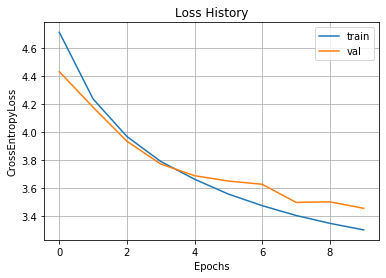

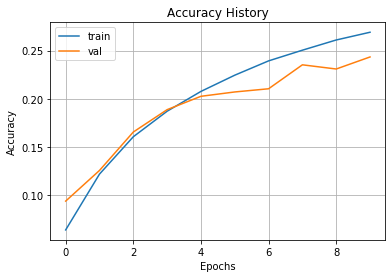

In [44]:
main()

In [20]:
img.shape, target

(torch.Size([10, 3, 64, 64]),
 tensor([ 49, 154, 176, 185,  61,  12,  47,  88, 185,  19]))

In [31]:
sm = get_small_model()

## TL;DR. Moar techniques on accuracy vs time trade-off (just for your information)

### Tensor type size

One of the hyperparameter affecting memory consumption is the precision (e.g. floating point number). The most popular choice is 32 bit however with several hacks* 16 bit arithmetics can save you approximately half of the memory without considerable loss of perfomance. This is called mixed precision training.

*https://arxiv.org/pdf/1710.03740.pdf

### Quantization

We can actually move further and use even lower precision like 8-bit integers:

* https://heartbeat.fritz.ai/8-bit-quantization-and-tensorflow-lite-speeding-up-mobile-inference-with-low-precision-a882dfcafbbd
* https://nervanasystems.github.io/distiller/quantization/
* https://arxiv.org/abs/1712.05877

### Pruning

The idea of pruning is to remove unnecessary (in terms of loss) weights. It can be measured in different ways: for example, by the norm of the weights (similar to L1 feature selection), by the magnitude of the activation or via Taylor expansion*.

One iteration of pruning consists of two steps:

1) Rank weights with some importance measure and remove the least important

2) Fine-tune the model

This approach is a bit computationally heavy but can lead to drastic (up to 150x) decrease of memory to store the weights. Moreover if you make use of structure in layers you can decrease also compute. For example, the whole convolutional filters can be removed.

*https://arxiv.org/pdf/1611.06440.pdf